In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_20newsgroups

from gensim import corpora, models, similarities, matutils
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess

from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

## Data loading

In [2]:
categories=['comp.sys.mac.hardware', 'soc.religion.christian', 'rec.sport.hockey', 'sci.med', 'sci.space']

dataset = fetch_20newsgroups(subset='train', categories=categories)
n_topics = len(categories)

In [3]:
X = dataset.data[0:100]
y = dataset.target[0:100]

## Preprocessing

In [4]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

# word frequency thresholds
max_df=500 
min_df=10

#### manual approach

In [5]:
dictionary = corpora.Dictionary(line.lower().split() for line in X)

# remove stop words
stop_ids = [dictionary.token2id[stopword] for stopword in STOPWORDS
            if stopword in dictionary.token2id]

# filtering by frequency
bad_ids = [tokenid for tokenid, docfreq in dictionary.dfs.iteritems() if docfreq <= min_df | docfreq >= max_df]
dictionary.filter_tokens(bad_ids=stop_ids + bad_ids, good_ids=None)

# remove gaps in id sequence after words that were removed
dictionary.compactify() 

print (dictionary)

Dictionary(8328 unique tokens: [u'cook@varmit.mdc.com', u'writings', u'georgeh@gjhsun', u'considered,', u'method),']...)


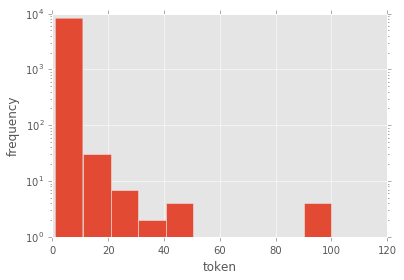

In [6]:
plt.hist(dictionary.dfs.values(), log=True)
plt.xlabel('token')
plt.ylabel('frequency')
plt.show()

#### gensim approach

In [7]:
def my_tokenizer(doc):
    return [token for token in simple_preprocess(doc) if token not in STOPWORDS]

In [8]:
dictionary = corpora.Dictionary(my_tokenizer(doc) for doc in X)

# filtering by frequency
bad_ids = [tokenid for tokenid, docfreq in dictionary.dfs.iteritems() if docfreq <= min_df | docfreq >= max_df]
dictionary.filter_tokens(bad_ids=bad_ids, good_ids=None)

# remove gaps in id sequence after words that were removed
dictionary.compactify() 

print (dictionary)

Dictionary(5822 unique tokens: [u'writings', u'foul', u'woods', u'lori', u'lord']...)


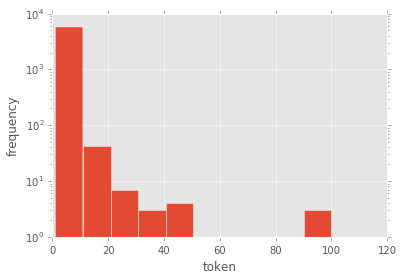

In [9]:
plt.hist(dictionary.dfs.values(), log=True)
plt.xlabel('token')
plt.ylabel('frequency')
plt.show()

#### nltk approach

In [10]:
from collections import defaultdict
frequency = defaultdict(int)

tokenizer = RegexpTokenizer(r'\w+')
p_stemmer = PorterStemmer()
# list for tokenized documents in loop
texts = []

# loop through document list
for i in X:
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)
    
    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in STOPWORDS]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # frequency counting
    for token in i:
        frequency[token] += 1
        
    # add tokens to list
    texts.append(stemmed_tokens)

# filtering by frequency
texts = [[token for token in text if (frequency[token] >= min_df) | (frequency[token] <= max_df)]
         for text in texts]

dictionary = corpora.Dictionary(texts)

#bad_ids = [tokenid for tokenid, docfreq in dictionary.dfs.iteritems() if docfreq <= min_df | docfreq >= max_df]

#dictionary.filter_tokens(bad_ids=bad_ids, good_ids=None)
#dictionary.compactify() 

print (dictionary)

Dictionary(5311 unique tokens: [u'inexperi', u'nwu', u'circuitri', u'doodah', u'foul']...)


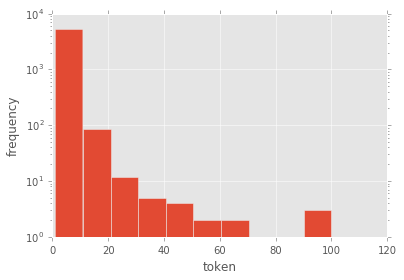

In [11]:
plt.hist(dictionary.dfs.values(), log=True)
plt.xlabel('token')
plt.ylabel('frequency')
plt.show()

## LDA

In [12]:
# create the 'bag of words' representation by counting the number of occurences 
# of each distinct word, converts the word to its integer word id and returns 
# the result as a sparse vector

corpus = [dictionary.doc2bow(text) for text in texts]

In [13]:
# transform to term-frequency inverse document-frequency (Tf–idf) scheme
tfidf = models.TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf[corpus]

In [14]:
# initialize LDA model
lda = models.ldamodel.LdaModel(corpus_tfidf, num_topics=n_topics, id2word = dictionary, passes=5)

In [15]:
# transform 'bag fo words' accordaing to LDA model
corpus_lda = lda[corpus_tfidf]

In [16]:
# marking up topics labels by maximum probability value
classes = np.array([np.argmax([j[1] for j in i], axis=0) for i in corpus_lda])
print 'Error fraction:', float(sum(classes != y)) / len(y)

Error fraction: 0.8


In [27]:
import itertools
def validate_with_mappings(preds, target, dataset):
    permutations = itertools.permutations([0, 1, 2, 3, 4])
    for a, b, c, d, e in permutations:
        mapping = {4:a, 3:b, 2:c, 1:d, 0:e}
        mapped_preds = [mapping[pred] for pred in preds]
        print float(sum(mapped_preds != target)) / len(target)
        
validate_with_mappings(classes, y, X)

0.82
0.82
0.81
0.77
0.86
0.82
0.74
0.74
0.76
0.77
0.81
0.82
0.75
0.71
0.78
0.79
0.78
0.83
0.76
0.72
0.79
0.8
0.74
0.79
0.8
0.8
0.79
0.75
0.84
0.8
0.83
0.83
0.79
0.77
0.84
0.82
0.84
0.8
0.81
0.79
0.81
0.83
0.85
0.81
0.82
0.8
0.77
0.79
0.73
0.73
0.75
0.76
0.8
0.81
0.84
0.84
0.8
0.78
0.85
0.83
0.8
0.81
0.74
0.72
0.82
0.79
0.81
0.82
0.75
0.73
0.78
0.75
0.77
0.73
0.8
0.81
0.8
0.85
0.88
0.84
0.85
0.83
0.85
0.87
0.83
0.84
0.77
0.75
0.85
0.82
0.81
0.86
0.75
0.77
0.83
0.8
0.78
0.74
0.81
0.82
0.76
0.81
0.89
0.85
0.86
0.84
0.81
0.83
0.84
0.85
0.78
0.76
0.81
0.78
0.81
0.86
0.75
0.77
0.83
0.8


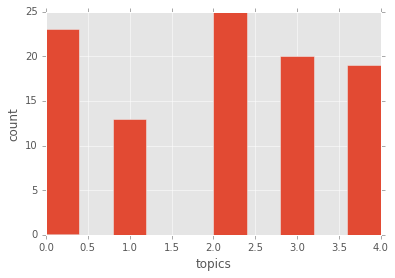

In [24]:
plt.hist(classes)
plt.xlabel('topics')
plt.ylabel('count')
plt.show()

In [17]:
df_before = pd.DataFrame([[j[1] for j in i] for i in corpus]).fillna(0)
df_after = pd.DataFrame([[j[1] for j in i] for i in corpus_lda]).fillna(0)

print df_before.shape, df_after.shape

(100, 1016) (100, 5)


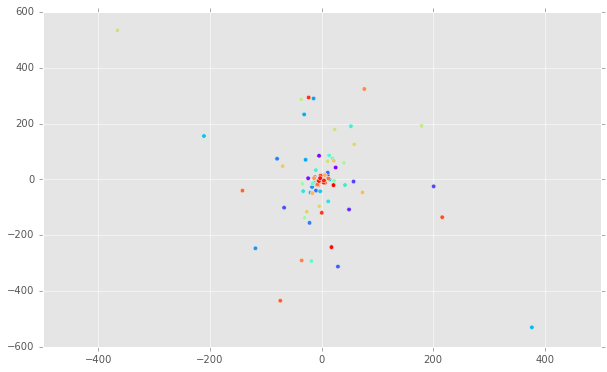

In [18]:
from sklearn import manifold
import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, 1, len(df_before)))
options = {
    'perplexity': 5.0, #is related to the number of nearest neighbors
    'early_exaggeration': 2.0,
    'learning_rate':1000.0,
    'angle': 0.5 # is a tradeoff between performance and accuracy? during optimization process
                 # range of 0.2 - 0.8. Angle less than 0.2 has quickly increasing computation 
                 # time and angle greater 0.8 has quickly increasing error.
}

tsne = manifold.TSNE(n_components = n_topics, init = 'pca', random_state = 0, perplexity=options['perplexity'], learning_rate=options['learning_rate'], early_exaggeration=options['early_exaggeration'])
data_2d_tsne = tsne.fit_transform(df_before)

plt.figure(figsize = (10, 6))
plt.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c = colors)

In [19]:
l = []
for i in corpus:
    l.append(len(i))
max(l)

1016

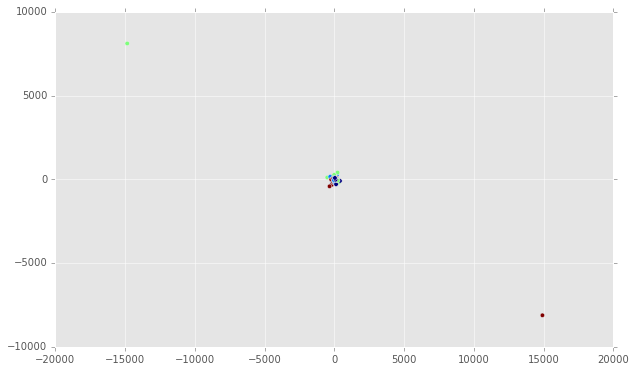

In [20]:
tsne1 = manifold.TSNE(n_components = n_topics, init = 'pca', random_state = 0, perplexity=options['perplexity'], learning_rate=options['learning_rate'], early_exaggeration=options['early_exaggeration'])
data_2d_tsne1 = tsne1.fit_transform(df_after)

plt.figure(figsize = (10, 6))
plt.scatter(data_2d_tsne1[:, 0], data_2d_tsne1[:, 1],c=y)